In [2]:
import numpy as np
import socket
import cv2
import matplotlib.pyplot as plt

## Install Stable Baseline3 version >= 2.0.0a5
#### Note some SB3 versions are not compatible with Gymnasium interface.

In [3]:
!pip install "stable-baselines3[extra] >= 2.0.0a5"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.7/181.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 14.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.3 MB/s eta 0:00:00
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=5a5e86239ff5c3733fe0d76ae479320fbc11a9486ae9e412ae2f5b26e823fdc0
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


## Run the Java Tetris Server (v0.6) using subprocess
#### The latest server can be found on GitHub ([JavaTetris4RL](https://github.com/aiotlab-teaching/JavaTetris4RL)).

In [4]:
# Download v0.5 server from AIoTLab website
!wget http://www.aiotlab.org/teaching/oop/tetris/TetrisTCPserver_v0.6.jar

--2024-01-02 02:28:28--  http://www.aiotlab.org/teaching/oop/tetris/TetrisTCPserver_v0.6.jar
Resolving www.aiotlab.org (www.aiotlab.org)... 52.219.125.103, 52.219.128.37, 52.219.125.95, ...
Connecting to www.aiotlab.org (www.aiotlab.org)|52.219.125.103|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3879189 (3.7M) [binary/octet-stream]
Saving to: ‘TetrisTCPserver_v0.6.jar’

TetrisTCPserver_v0. 100%[===================>]   3.70M  2.77MB/s    in 1.3s    

2024-01-02 02:28:30 (2.77 MB/s) - ‘TetrisTCPserver_v0.6.jar’ saved [3879189/3879189]



In [5]:
import subprocess
subprocess.Popen(["java","-jar","TetrisTCPserver_v0.6.jar"])

<Popen: returncode: None args: ['java', '-jar', 'TetrisTCPserver_v0.6.jar']>

## Create our own Tetris Test environment by inheriting gym.Env class

In [6]:
import gymnasium as gym
from gymnasium import spaces

In [7]:
class TetrisEnv(gym.Env):

    metadata = {"render_modes": ["human"], "render_fps": 20}

    '''
        The supported actions are
        0: move -1
        1: move 1
        2: rotate 0 // counter-clockwise
        3: rotate 1 // clockwise
        4: drop down
    '''
    N_DISCRETE_ACTIONS = 5

    IMG_HEIGHT = 200
    IMG_WIDTH = 100
    IMG_CHANNELS = 3


    def __init__(self, host_ip="127.0.0.1", host_port=10612):
        super().__init__()

        self.action_space = spaces.Discrete(self.N_DISCRETE_ACTIONS)
        # Example for using image as input (channel-first; channel-last also works):
        self.observation_space = spaces.Box(low=0, high=255,
                                            shape=(self.IMG_HEIGHT, self.IMG_WIDTH, self.IMG_CHANNELS), dtype=np.uint8)
        self.server_ip = host_ip
        self.server_port = host_port

        self.client_sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.client_sock.connect((self.server_ip, self.server_port))

    def step(self, action):
        if action == 0:
            self.client_sock.sendall(b"move -1\n")
        elif action == 1:
            self.client_sock.sendall(b"move 1\n")
        elif action == 2:
            self.client_sock.sendall(b"rotate 0\n")
        elif action == 3:
            self.client_sock.sendall(b"rotate 1\n")
        elif action == 4:
            self.client_sock.sendall(b"drop\n")

        terminated, lines, height, holes, observation = self.get_tetris_server_response(self.client_sock)
        self.observation = observation

        reward = 0
        if action == 4: # Drop reward
            reward += 5

        # Negative height reward
        if height > self.height:
            reward -= (height - self.height)*5

        # Positive hole reduction reward
        if holes < self.holes:
            reward += (self.holes - holes)*10

        if lines > self.lines_removed:
            reward = reward + (lines - self.lines_removed)*1000
            self.lines_removed = lines

        self.holes = holes
        self.height = height
        self.lifetime += 1
        truncated = False
        info = {'removed_lines':self.lines_removed, 'lifetime':self.lifetime}
        return (observation, reward, terminated, truncated, info)

    def reset(self, seed=None, options=None):
        self.client_sock.sendall(b"start\n")
        terminated, lines, height, holes, observation = self.get_tetris_server_response(self.client_sock)
        self.observation = observation
        self.reward = 0
        self.lines_removed = 0
        self.holes = 0
        self.height = 0
        self.lifetime = 0
        info = {}
        return observation, info

    def render(self):
        ''''''
        #if self.render_mode == "console":
        #    print('Total reward ' + str(self.reward))
        '''
        if self.render_mode == "human":
            cv2.imshow("Image", self.observation)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
        '''

    def close(self):
        self.client_sock.close()

    def get_tetris_server_response(self, sock):
        is_game_over = (sock.recv(1) == b'\x01')
        removed_lines = int.from_bytes(sock.recv(4), 'big')
        height = int.from_bytes(sock.recv(4), 'big')
        holes = int.from_bytes(sock.recv(4), 'big')
        img_size = int.from_bytes(sock.recv(4), 'big')
        img_png = sock.recv(img_size)

        nparr = np.frombuffer(img_png, np.uint8)
        np_image = cv2.imdecode(nparr, -1)

        return is_game_over, removed_lines, height, holes, np_image

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Use SB3 env_checker to check our environment

In [8]:
from stable_baselines3.common.env_checker import check_env

env = TetrisEnv()
# It will check your custom environment and output additional warnings if needed
# No response may be caused by mismatched action state definition and implementation
check_env(env)

## Randomly test the environment

In [9]:
obs, info = env.reset()
n_steps = 20
for _ in range(n_steps):
    # Random action
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)

    env.render() # We render nothing now

    if terminated:
        break

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


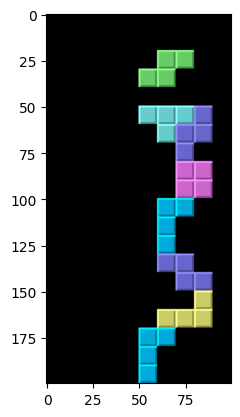

In [10]:
# Show the final screen
%matplotlib inline
plt.imshow(obs)

## Create an environment with 30 client threads

In [11]:
from stable_baselines3 import PPO, A2C, DQN
from stable_baselines3.common.env_util import make_vec_env

In [12]:
# Let's try A2C by creating 30 environments
vec_env = make_vec_env(TetrisEnv, n_envs=30)

## We choose A2C with CNN policy, and train 2,000,000 steps

In [13]:
model = A2C("CnnPolicy", vec_env, verbose=1, tensorboard_log="./sb3_log/").learn(2000000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to ./sb3_log/A2C_1
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 114      |
|    ep_rew_mean        | -30.5    |
| time/                 |          |
|    fps                | 321      |
|    iterations         | 100      |
|    time_elapsed       | 46       |
|    total_timesteps    | 15000    |
| train/                |          |
|    entropy_loss       | -0.00102 |
|    explained_variance | 0.917    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.00182  |
|    value_loss         | 80.5     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 113      |
|    ep_rew_mean        | -22.3    |
| time/                 |          |
|    fps                | 337      |
|    iterations         | 200      |
|    time_elapsed       | 

In [14]:
%load_ext tensorboard
%tensorboard --logdir /content/sb3_log/A2C_1/

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>

## Test our model with 1000 steps and record all plays.

In [15]:
import os
import shutil

# Test the trained agent
# using the vecenv
obs = vec_env.reset()
test_steps = 1000

replay_folder = './replay'
if os.path.exists(replay_folder):
    shutil.rmtree(replay_folder)

n_env = obs.shape[0] # Number of environments. A2C will play all envs
ep_id = np.zeros(n_env, int)
ep_steps = np.zeros(n_env, int)
cum_reward = np.zeros(n_env)
max_reward = -1e10
max_game_id = 0
max_ep_id = 0
max_rm_lines = 0
max_lifetime = 0

for step in range(test_steps):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)

    if step % 100 == 0:
        print(f"Step {step}")
        print("Action: ", action)
        print("reward=", reward, " done=", done)

    for eID in range(n_env):
        cum_reward[eID] += reward[eID]
        folder = f'{replay_folder}/{eID}/{ep_id[eID]}'
        if not os.path.exists(folder):
            os.makedirs(folder)
        fname = folder + '/' + '{:06d}'.format(ep_steps[eID]) + '.png'
        cv2.imwrite(fname, obs[eID])
        #cv2.imshow("Image" + str(eID), obs[eID])
        #cv2.waitKey(10)
        ep_steps[eID] += 1

        if done[eID]:
            if cum_reward[eID] > max_reward:
                max_reward = cum_reward[eID]
                max_game_id = eID
                max_ep_id = ep_id[eID]
                max_rm_lines = info[eID]['removed_lines']
                max_lifetime = info[eID]['lifetime']

            ep_id[eID] += 1
            cum_reward[eID] = 0
            ep_steps[eID] = 0

#cv2.destroyAllWindows()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Step 0
Action:  [0 0 3 0 0 0 0 0 0 3 0 0 0 0 0 3 3 0 0 0 0 0 3 0 3 0 0 3 0 3]
reward= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]  done= [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]
Step 100
Action:  [0 3 0 0 0 0 4 0 4 3 0 0 0 2 4 4 3 0 0 0 0 0 4 3 0 0 3 0 2 3]
reward= [  0.   0.   0.   0. -10.   0.   5.   0.   5.   0.   0.   0.   0.   0.
   5. -10.   0.   0.   0.   0.   0.   0.   5.   0.   0.   0.   0.   0.
   0.   0.]  done= [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]
Step 200
Action:  [4 0 0 4 0 4 3 0 4 0 0 0 3 0 0 3 0 2 4 0 0 0 0 3 0 0 0 4 0 4]
reward= [  5.   0. -10.   0. -10.   0.   0.   0.   5.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   5.   0.   0.   

In [16]:
best_replay_path = replay_folder + '/' + str(max_game_id) + '/' + str(max_ep_id)

print("After playing 30 envs each for ", test_steps, " steps:")
print(" Max reward=", max_reward, " Best video: " + best_replay_path)
print(" Removed lines=", max_rm_lines, " lifetime=", max_lifetime)

After playing 30 envs each for  1000  steps:
 Max reward= 60.0  Best video: ./replay/11/4
 Removed lines= 0  lifetime= 116


## Make a gif image to visualize the best play

In [17]:
import glob
import imageio

filenames = sorted(glob.glob(best_replay_path + '/*.png'))

images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('replay.gif', images, loop=0)

<ipython-input-17-8f892e7667df>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


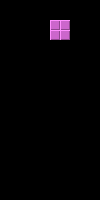

In [18]:
from IPython.display import Image
Image(filename='replay.gif')

In [19]:
with open('submission.csv', 'w') as fs:
    fs.write('id,removed_lines,played_steps\n')
    fs.write(f'0,{max_rm_lines},{max_lifetime}\n')
    fs.write(f'1,{max_rm_lines},{max_lifetime}\n')

In [20]:
# Upload your results to Kaggle
from IPython.display import FileLink
FileLink('submission.csv')

/content/submission.csv

In [24]:
model.save('112C52012_a2c_30env_1M.zip')

In [25]:
from IPython.display import FileLink
FileLink('112C52012_a2c_30env_1M.zip')

/content/112C52012_a2c_30env_1M.zip

In [26]:
# You can load your model for future testing
test_model = A2C.load('112C52012_a2c_30env_1M.zip')